<a href="https://colab.research.google.com/github/dchaithanya123/ZeoTap/blob/main/Dinnipati_Chaithanya_Kumar_Reddy_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Customers Dataset Columns: Index(['CustomerID', 'CustomerName', 'Region', 'SignupDate'], dtype='object')
Transactions Dataset Columns: Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price'],
      dtype='object')
Davies-Bouldin Index: 1.337


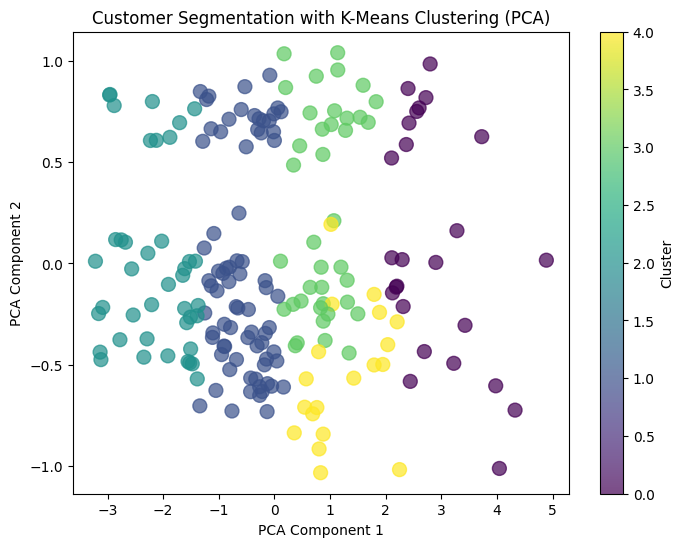

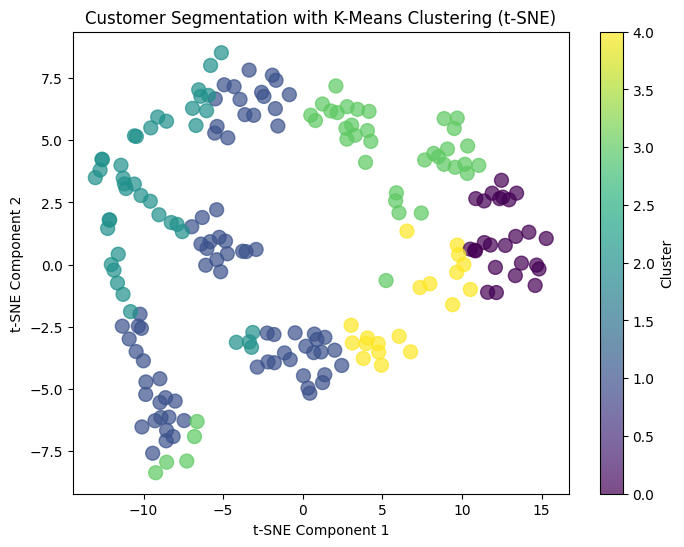

Cluster Summary:
   Cluster  avg_total_spent  avg_total_quantity  avg_num_transactions
0        0      6573.586400           23.600000              8.360000
1        1      2844.388000           10.693333              4.360000
2        2      1235.929024            5.073171              2.268293
3        3      4744.443846           16.000000              5.743590
4        4      4032.652632           16.473684              7.736842


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
from sklearn.manifold import TSNE

# Load datasets
customers = pd.read_csv('/content/Customers.csv')
transactions = pd.read_csv('/content/Transactions.csv')

# Inspect the column names of datasets
print("Customers Dataset Columns:", customers.columns)
print("Transactions Dataset Columns:", transactions.columns)

# Clean column names
customers.columns = customers.columns.str.strip()
transactions.columns = transactions.columns.str.strip()

# Merge customers and transactions on 'CustomerID'
merged_data = pd.merge(customers, transactions, on='CustomerID', how='inner')

# Feature engineering: Aggregate transaction data for each customer
customer_transactions = merged_data.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    total_quantity=('Quantity', 'sum'),
    num_transactions=('TransactionID', 'nunique')
).reset_index()

# Merge the profile data from the customers dataset with the aggregated transaction data
customer_profile = pd.merge(customers[['CustomerID', 'Region']], customer_transactions, on='CustomerID', how='inner')

# Feature preprocessing: Standardizing the numerical data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_profile[['total_spent', 'total_quantity', 'num_transactions']])

# One-hot encode the 'Region' column
customer_profile_encoded = pd.get_dummies(customer_profile[['Region']], drop_first=True)

# Combine the scaled numerical features with the encoded categorical features
final_features = np.hstack([scaled_features, customer_profile_encoded])

# Perform clustering using K-Means with a chosen number of clusters
kmeans = KMeans(n_clusters=5, random_state=42)  # Try with 5 clusters, but can experiment with other values
clusters = kmeans.fit_predict(final_features)

# Add cluster labels to the customer profile
customer_profile['Cluster'] = clusters

# Calculate the Davies-Bouldin Index
db_index = davies_bouldin_score(final_features, clusters)
print(f'Davies-Bouldin Index: {db_index:.3f}')

# Perform PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(final_features)

# Plot the clusters in 2D using PCA
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', marker='o', s=100, alpha=0.7)
plt.title('Customer Segmentation with K-Means Clustering (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Alternatively, use t-SNE for better visualization (especially for non-linear clusters)
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(final_features)

plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clusters, cmap='viridis', marker='o', s=100, alpha=0.7)
plt.title('Customer Segmentation with K-Means Clustering (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Summary of clustering results
cluster_summary = customer_profile.groupby('Cluster').agg(
    avg_total_spent=('total_spent', 'mean'),
    avg_total_quantity=('total_quantity', 'mean'),
    avg_num_transactions=('num_transactions', 'mean')
).reset_index()

print("Cluster Summary:")
print(cluster_summary)

# Save results to a CSV for reporting
customer_profile[['CustomerID', 'Cluster']].to_csv('Customer_Segmentation_Results.csv', index=False)

